In [235]:
import numpy as np
import pandas as pd
import scipy.io
import pyriemann as pr
import networkx as nx

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

In [21]:
#'P_' + labels['patient_number'][i][1:]
labels = pd.read_csv("data/targets 27.02.2018.csv", sep=";")

idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "Positive", "Negative", "TLEPositive"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8.0,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,8.0,NaN
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7.0,9.0
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,8.0,NaN
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8.0,NaN


In [349]:
train_labels, test_labels = train_test_split(labels['patient_number'])

In [360]:
# X = pd.read_csv('correlation_matrix/P_001.csv', index_col=0) + lam*np.eye(N)
N = 117
lam = 30

data = []
for l in train_labels:
    X_new = pd.read_csv('correlation_matrix/P_{}.csv'.format(l[1:]), index_col=0)
    X_graph = nx.Graph(data = np.asarray(X_new))
    X_lp = nx.laplacian_matrix(X_graph)
    data.append(X_lp.toarray() + lam*np.eye(N))

# y = labels['target'][:2]
#X = np.concatenate((X, np.atleast_3d(X_new)),axis =2)
#np.atleast_3d(X_new).reshape(1,1,-1)
X_train = np.stack(data, axis=0)
y_train = labels.set_index('patient_number').loc[train_labels]['D/no D']

In [361]:
data = []
for i in test_labels:
    X_new = pd.read_csv('correlation_matrix/P_{}.csv'.format(l[1:]), index_col=0)
    X_graph = nx.Graph(data = np.asarray(X_new))
    X_lp = nx.laplacian_matrix(X_graph)
    data.append(X_lp.toarray() + lam*np.eye(N))

X_test = np.stack(data, axis=0)
y_test = labels.set_index('patient_number').loc[test_labels]['D/no D']

In [22]:
clf = pr.classification.TSclassifier(tsupdate=True)

#clf = pr.classification.TSclassifier(tsupdate=True,clf=LogisticRegression(C = 1, penalty = 'l2'))

In [23]:
clf.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [364]:
clf.score(X_test, y_test)

0.44

In [365]:
clf.score(X_train, y_train)

0.90666666666666662

In [366]:
clf.predict(X_train)

array([1, 5, 5, 5, 1, 1, 1, 5, 1, 1, 1, 5, 1, 1, 1, 1, 5, 5, 1, 1, 5, 5, 5,
       1, 1, 5, 1, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 1, 1, 5, 1,
       5, 1, 5, 5, 5, 1, 1, 1, 1, 1, 1, 5, 5, 1, 5, 5, 1, 1, 1, 1, 1, 1, 5,
       5, 1, 5, 5, 5, 1])

In [367]:
clf.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [208]:
clf = pr.classification.KNearestNeighbor()

In [209]:
clf.fit(X_train, y_train)

KNearestNeighbor(metric='riemann', n_jobs=1, n_neighbors=5)

# Adjacency matrices

In [3]:
# mat1 = scipy.io.loadmat('correlation_matrix/resultsROI_Condition001.mat')
# mat2 = scipy.io.loadmat('correlation_matrix/resultsROI_Condition002.mat')

# conn1 = mat1['Z'][:,:-1,:]
# conn2 = mat2['Z'][:,:-1,:]

adj1 = scipy.io.loadmat('correlation_matrix/adjacency_matrices_last_50_18_02_18.mat')
adj2 = scipy.io.loadmat('correlation_matrix/adjacency_matrixes_first_50_18_02_2018.mat')

adj1 = adj1['A']
adj2 = adj2['A']

In [162]:
X_full = np.concatenate((adj1,adj2), axis = 2)

In [165]:
data = []
lam = .9
for i in range(100):
    X_graph = nx.Graph(data = np.asarray(X_full[:,:,i]))
    X_lp = nx.laplacian_matrix(X_graph)
    data.append(X_lp.toarray() + lam*np.eye(164))
    
X = np.stack(data, axis=0)
y = labels['E/no E']

### LR

In [194]:
param = {'clf__C': np.logspace(-6,1,6),
        'clf__penalty': ['l2', 'l1']}
clf = pr.classification.TSclassifier(tsupdate=True, clf=LogisticRegression())
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [195]:
lr_grid = GridSearchCV(clf, param, cv = cv, verbose = 2, scoring='f1_micro')
lr_grid.fit(X, y)

Fitting 25 folds for each of 12 candidates, totalling 300 fits
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] .................... clf__C=1e-06, clf__penalty=l2, total=   5.6s
[CV] clf__C=1e-06, clf__penalty=l2 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] .................... clf__C=1e-06, clf__penalty=l2, total=   5.7s
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] .................... clf__C=1e-06, clf__penalty=l2, total=   5.9s
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] .................... clf__C=1e-06, clf__penalty=l2, total=   5.7s
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] .................... clf__C=1e-06, clf__penalty=l2, total=   5.7s
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] .................... clf__C=1e-06, clf__penalty=l2, total=   6.1s
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] .................... clf__C=1e-06, clf__penalty=l2, total=   6.0s
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] .................... clf__C=1e-06, clf__penalty=l2, total=   6.1s
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 50.4min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x111275ef0>,
       error_score='raise',
       estimator=TSclassifier(clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       metric='riemann', tsupdate=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': array([  1.00000e-06,   2.51189e-05,   6.30957e-04,   1.58489e-02,
         3.98107e-01,   1.00000e+01]), 'clf__penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=2)

In [196]:
lr_grid.best_estimator_

TSclassifier(clf=LogisticRegression(C=0.01584893192461111, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       metric='riemann', tsupdate=True)

In [197]:
lr_grid.best_score_

0.61199999999999999

### SVC

In [241]:
param = {'clf__C': [10 ** i for i in range(-6, 4, 2)],
        'clf__kernel': ["rbf", "linear"],
        'clf__gamma': [10 ** i for i in range(-6, 2, 2)]}
clf = pr.classification.TSclassifier(tsupdate=True, clf=SVC())
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [242]:
svc_grid = GridSearchCV(clf, param, cv = cv, verbose = 2, scoring='f1_micro')
svc_grid.fit(X, y)

Fitting 25 folds for each of 40 candidates, totalling 1000 fits
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................
[CV] .. clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf, total=   5.3s
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] .. clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf, total=   5.6s
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................
[CV] .. clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf, total=   5.4s
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................
[CV] .. clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf, total=   5.2s
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................
[CV] .. clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf, total=   5.0s
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................
[CV] .. clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf, total=   5.1s
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................
[CV] .. clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf, total=   6.6s
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................
[CV] .. clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf, total=   6.0s
[CV] clf__C=1e-06, clf__gamma=1e-06, clf__kernel=rbf .................
[CV] .

/usr/local/lib/python3.6/site-packages/pyriemann/utils/base.py:12: RuntimeWarning: invalid value encountered in log
  eigvals = numpy.diag(operator(eigvals))


ValueError: Covariance matrices must be positive definite. Add regularization to avoid this error.

In [ ]:
svc_grid.best_estimator_

In [ ]:
svc_grid.best_score_

### MDM

In [198]:
param = {'metric': ['riemann', 'logeuclid', 'euclid', 'logdet', 'identity']}
mdm_clf = pr.classification.MDM()
mdm_grid = GridSearchCV(mdm_clf, param, cv = cv, verbose = 2, scoring='f1_micro')
mdm_grid.fit(X, y)

Fitting 25 folds for each of 5 candidates, totalling 125 fits
[CV] metric=riemann ..................................................
[CV] ................................... metric=riemann, total=   3.8s
[CV] metric=riemann ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................................... metric=riemann, total=   3.8s
[CV] metric=riemann ..................................................
[CV] ................................... metric=riemann, total=   3.8s
[CV] metric=riemann ..................................................
[CV] ................................... metric=riemann, total=   3.7s
[CV] metric=riemann ..................................................
[CV] ................................... metric=riemann, total=   3.8s
[CV] metric=riemann ..................................................
[CV] ................................... metric=riemann, total=   3.8s
[CV] metric=riemann ..................................................
[CV] ................................... metric=riemann, total=   3.7s
[CV] metric=riemann ..................................................
[CV] ................................... metric=riemann, total=   3.7s
[CV] metric=riemann ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  9.4min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x111275ef0>,
       error_score='raise', estimator=MDM(metric='riemann', n_jobs=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'metric': ['riemann', 'logeuclid', 'euclid', 'logdet', 'identity']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=2)

In [199]:
mdm_grid.best_estimator_

MDM(metric='riemann', n_jobs=1)

In [205]:
mdm_grid.best_score_

0.58199999999999996

### Test

In [232]:
n_objects = 100

def repeated_cross_val_predict_proba(estimator, X, y, cv, pos_label=None, file=None):
    
    if pos_label is None:
        y_enc = pd.Series(LabelEncoder().fit_transform(y), index=y.index)
    else:
        y_enc = pd.Series(y == pos_label, dtype=int)
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm_notebook(cv.split(X, y_enc)):
        estimator.fit(X[idx_tr,:,:], y_enc.iloc[idx_tr])
        pred_te = np.array(estimator.predict_proba(X[idx_te,:,:]), dtype=float)
        for i, idx in enumerate(idx_te):
            predictions[idx].append(pred_te[i, 1])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [233]:
def plot_roc_curve(y, probas, pos_label, idx, average_repeats=False):
    if average_repeats:
        y_true = pd.Series(y == pos_label, dtype=int)
        y_score = probas[idx].mean(axis=1)
    else:
        n_repeats = probas.shape[1]
        y_true = pd.Series(np.tile(y == pos_label, (n_repeats)), dtype=int)
        y_score = probas[idx].values.T.reshape(-1, 1)
    fpr, tpr, t = roc_curve(y_true=y_true, y_score=y_score)
    plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive rate", fontsize=14)
    plt.ylabel("True Positive rate", fontsize=14)
    plt.show()
    print("auc =", roc_auc_score(y_true, y_score))
    return fpr, tpr, t

In [237]:
def get_fpr_fnr(fpr, tpr, fix_fpr_l=[0.1, 0.15, 0.2, 0.3]):
    fnr_l = []
    for fix_fpr in fix_fpr_l:
        fnr_l.append(1 - tpr[fpr <= fix_fpr][-1])
    fpr_fnr_table = pd.DataFrame(np.column_stack((fix_fpr_l, fnr_l)), columns=["False Positive rate (fixed)", "False Negative rate"])
    display(fpr_fnr_table)
    return fpr_fnr_table

In [227]:
pos_label = label_to_idx["E"]
E_idx = labels["E/no E"].notnull()

## MDM

In [228]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
probas_E = repeated_cross_val_predict_proba(mdm_grid.best_estimator_, X, y, cv=cv, pos_label=pos_label)


0it [00:00, ?it/s]
1it [00:04,  4.25s/it]
2it [00:08,  4.14s/it]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100it [07:59,  4.80s/it]


NameError: name 'roc_curve' is not defined

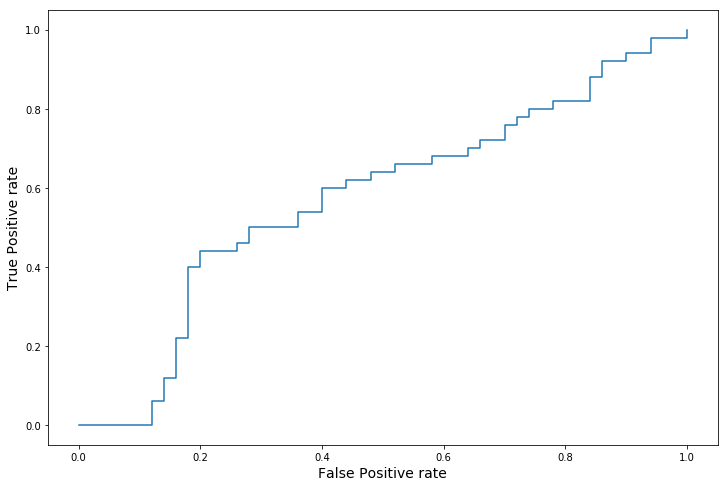

auc = 0.5736


,False Positive rate (fixed),False Negative rate
0,0.10,1.00
1,0.15,0.88
2,0.20,0.56
3,0.30,0.50


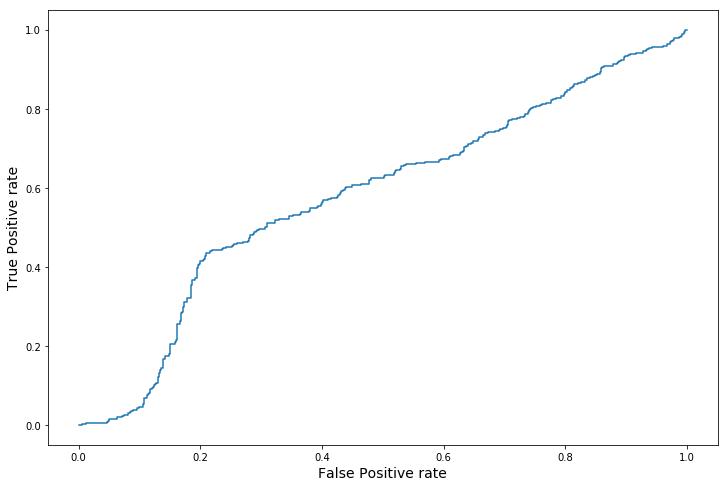

auc = 0.581612


,False Positive rate (fixed),False Negative rate
0,0.10,0.954
1,0.15,0.796
2,0.20,0.586
3,0.30,0.504


In [238]:
# average probabilities between repetitions
fpr, tpr, t = plot_roc_curve(y, probas_E, pos_label, E_idx, average_repeats=True)
get_fpr_fnr(fpr, tpr);

# without averaging
fpr, tpr, t = plot_roc_curve(y, probas_E, pos_label, E_idx)
get_fpr_fnr(fpr, tpr);

### LR

In [239]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
probas_E = repeated_cross_val_predict_proba(lr_grid.best_estimator_, X, y, cv=cv, pos_label=pos_label)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

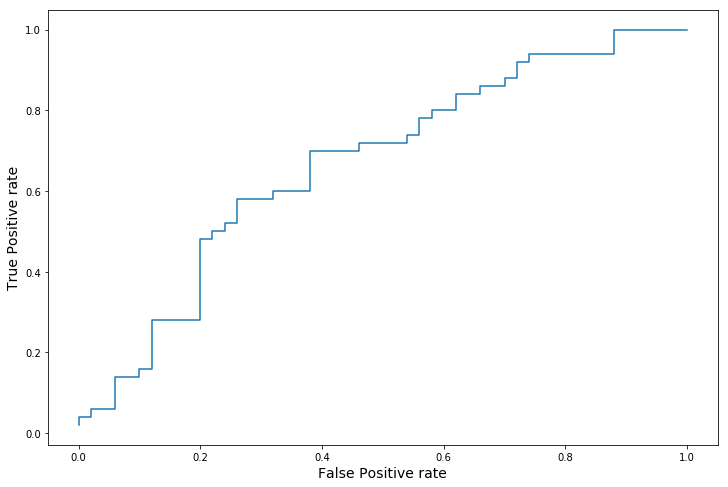

auc = 0.6668


,False Positive rate (fixed),False Negative rate
0,0.10,0.84
1,0.15,0.72
2,0.20,0.52
3,0.30,0.42


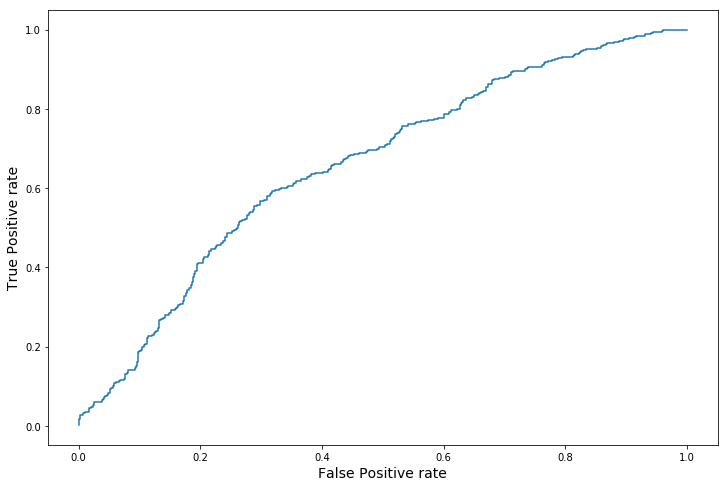

auc = 0.659008


,False Positive rate (fixed),False Negative rate
0,0.10,0.810
1,0.15,0.716
2,0.20,0.590
3,0.30,0.432


In [240]:
# average probabilities between repetitions
fpr, tpr, t = plot_roc_curve(y, probas_E, pos_label, E_idx, average_repeats=True)
get_fpr_fnr(fpr, tpr);

# without averaging
fpr, tpr, t = plot_roc_curve(y, probas_E, pos_label, E_idx)
get_fpr_fnr(fpr, tpr);

## SVC

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
probas_E = repeated_cross_val_predict_proba(svc_grid.best_estimator_, X, y, cv=cv, pos_label=pos_label)

In [ ]:
# average probabilities between repetitions
fpr, tpr, t = plot_roc_curve(y, probas_E, pos_label, E_idx, average_repeats=True)
get_fpr_fnr(fpr, tpr);

# without averaging
fpr, tpr, t = plot_roc_curve(y, probas_E, pos_label, E_idx)
get_fpr_fnr(fpr, tpr);